In [220]:
suppressMessages(library(devtools))
suppressMessages(library(limma))
suppressMessages(library(edgeR))
suppressMessages(library(ggplot2))
suppressMessages(library(DESeq2))
suppressMessages(library(stringr))
suppressMessages(library(ggrepel))
suppressMessages(library(apeglm))
suppressMessages(library(tximport))
suppressMessages(library(vsn))
suppressMessages(library(repr))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(tximportData))
suppressMessages(library(BiocParallel))
suppressMessages(library(glmpca))

In [10]:
setwd('/mnt/nfs/shared/999993-Bioda/projects/kaja_transposons/RNA_SEQ/KPSP_MIX1+2/')
getwd()

[1] "/mnt/nfs/shared/999993-Bioda/projects/kaja_transposons/RNA_SEQ/KPSP_MIX1+2"

In [4]:
# suppress warning messages
options(warn=-1)

In [5]:
# disable scientific notation
options(scipen=999)

In [6]:
register(MulticoreParam(35))

In [129]:
# function to store heatmaps as png
save_pheatmap_png <- function(x, filename, width=580, height=480) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   invisible(dev.off())
}

In [2]:
te_samples <- read.table(file.path("TETRANSCRIPTS", "te_samples.txt"), header = FALSE)
te_files <- file.path("TETRANSCRIPTS", paste0(te_samples$V1, ".cntTable"))
#names(files_genes) <- paste0("TE", 1:16)
te_files

[1] "TETRANSCRIPTS/TE01.cntTable" "TETRANSCRIPTS/TE02.cntTable"
 [3] "TETRANSCRIPTS/TE03.cntTable" "TETRANSCRIPTS/TE04.cntTable"
 [5] "TETRANSCRIPTS/TE05.cntTable" "TETRANSCRIPTS/TE06.cntTable"
 [7] "TETRANSCRIPTS/TE07.cntTable" "TETRANSCRIPTS/TE08.cntTable"
 [9] "TETRANSCRIPTS/TE09.cntTable" "TETRANSCRIPTS/TE10.cntTable"
[11] "TETRANSCRIPTS/TE11.cntTable" "TETRANSCRIPTS/TE12.cntTable"
[13] "TETRANSCRIPTS/TE13.cntTable" "TETRANSCRIPTS/TE14.cntTable"
[15] "TETRANSCRIPTS/TE15.cntTable" "TETRANSCRIPTS/TE16.cntTable"

In [62]:
condition = factor(rep(c('C','T'), each = 8))

In [69]:
dge_te <- readDGE(te_files, 
                  columns=c(1,2), 
                  group=condition, 
                  norm.factors = calcNormFactors(),
                  labels=te_samples$V1)

In [70]:
dge_te

,files,group,lib.size,norm.factors
,<chr>,<fct>,<dbl>,<dbl>
TE01,TETRANSCRIPTS/TE01.cntTable,C,25650321,1
TE02,TETRANSCRIPTS/TE02.cntTable,C,25383264,1
TE03,TETRANSCRIPTS/TE03.cntTable,C,25857305,1
TE04,TETRANSCRIPTS/TE04.cntTable,C,26872072,1
TE05,TETRANSCRIPTS/TE05.cntTable,C,22584665,1
TE06,TETRANSCRIPTS/TE06.cntTable,C,22469354,1
TE07,TETRANSCRIPTS/TE07.cntTable,C,34935783,1
TE08,TETRANSCRIPTS/TE08.cntTable,C,21336683,1
TE09,TETRANSCRIPTS/TE09.cntTable,T,31368269,1


In [71]:
mat_te <- dge_te$counts

In [101]:
tail(mat_te)

,TE01,TE02,TE03,TE04,TE05,TE06,TE07,TE08,TE09,TE10,TE11,TE12,TE13,TE14,TE15,TE16
X9_LINE:L1:LINE,555,369,430,347,391,359,549,489,671,311,136,443,375,352,324,220
Zaphod2:hAT-Tip100:DNA,206,145,132,228,174,200,334,233,268,141,62,156,159,138,141,179
Zaphod3:hAT-Tip100:DNA,675,454,528,746,484,653,930,646,745,407,196,529,502,533,497,429
Zaphod:hAT-Tip100:DNA,448,462,397,513,381,417,556,362,538,342,181,378,420,430,365,353
hAT-16_Crp:hAT-Charlie:DNA,12,16,21,11,12,10,36,23,44,12,5,26,31,19,16,13
hAT-N1_Mam:hAT-Tip100:DNA,489,309,330,385,327,383,673,393,463,330,139,409,318,330,318,329


In [111]:
mat_te <- mat_te[which(grepl(":", rownames(mat_te), fixed=TRUE)),]

In [148]:
# subset of Alu and L1
mat_sub <- mat_te[(which(grepl("Alu", rownames(mat_te), fixed=TRUE) | grepl("L1", rownames(mat_te), fixed=TRUE))),]

In [150]:
head(mat_sub)

,TE01,TE02,TE03,TE04,TE05,TE06,TE07,TE08,TE09,TE10,TE11,TE12,TE13,TE14,TE15,TE16
Alu,2073,1566,1583,1951,1527,1769,2865,1766,2168,1764,551,1942,1584,1683,1538,1387
AluJb,165864,131845,121493,164222,132443,146507,238929,137558,173496,134370,42374,155707,138926,124791,123297,111698
AluJo,97005,77031,72032,94565,75212,84777,138952,80329,100131,76744,23861,88727,79989,72646,70390,66077
AluJr4,28419,22048,21552,26396,21386,23904,40292,23597,30838,23091,6758,25075,22172,20498,20497,18830
AluJr,109420,85501,81541,104997,84097,93766,152668,89296,113167,85557,26509,98605,87738,80754,79204,74056
AluSc5,4208,3466,2863,4395,3357,4001,6482,3501,4700,3566,1130,4187,4364,3356,3285,2874


In [112]:
id_list = rownames(mat_te)
for (i in 1:length(id_list)) {
  id_list[i] <- vapply(strsplit(id_list[i], ":", fixed = TRUE), "[", "", 1)
}
rownames(mat_te) <- id_list

In [114]:
head(mat_te)

,TE01,TE02,TE03,TE04,TE05,TE06,TE07,TE08,TE09,TE10,TE11,TE12,TE13,TE14,TE15,TE16
(CATTC)n,0,1,2,0,2,2,1,0,0,0,2,7,1,0,7,1
(GAATG)n,0,3,3,3,0,0,0,1,2,0,0,4,3,5,1,2
7SK,65546,69691,53540,52532,41232,44885,54601,21896,44113,29818,43023,15938,51303,36769,41312,36225
ACRO1,4,8,3,26,5,2,7,4,6,7,1,4,7,7,9,4
ALR/Alpha,237,307,304,765,375,334,530,231,884,464,163,420,507,366,610,691
Alu,2073,1566,1583,1951,1527,1769,2865,1766,2168,1764,551,1942,1584,1683,1538,1387


In [115]:
colnames(mat_te)

[1] "TE01" "TE02" "TE03" "TE04" "TE05" "TE06" "TE07" "TE08" "TE09" "TE10"
[11] "TE11" "TE12" "TE13" "TE14" "TE15" "TE16"

In [158]:
coldata <- data.frame(samples=colnames(mat_sub), 
                      condition=condition, 
                      stringsAsFactors=FALSE)

In [159]:
#design <- model.matrix(~0+condition)
#colnames(design) <- c("C","T")
#contrast <- makeContrasts(T-C, levels = design)

In [160]:
dds_te <- DESeqDataSetFromMatrix(countData = mat_sub, 
                                 colData = coldata, 
                                 design = ~ condition)

converting counts to integer mode



In [161]:
dds_te

class: DESeqDataSet 
dim: 179 16 
metadata(1): version
assays(1): counts
rownames(179): Alu AluJb ... L1PBb L1PREC2
rowData names(0):
colnames(16): TE01 TE02 ... TE15 TE16
colData names(2): samples condition

In [162]:
dds_te$samples

[1] "TE01" "TE02" "TE03" "TE04" "TE05" "TE06" "TE07" "TE08" "TE09" "TE10"
[11] "TE11" "TE12" "TE13" "TE14" "TE15" "TE16"

In [163]:
dds_te$condition

[1] C C C C C C C C T T T T T T T T
Levels: C T

In [164]:
dds_te <- DESeq2::DESeq(dds_te)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [165]:
colnames(mcols(dds_te))

[1] "baseMean"                       "baseVar"                       
 [3] "allZero"                        "dispGeneEst"                   
 [5] "dispGeneIter"                   "dispFit"                       
 [7] "dispersion"                     "dispIter"                      
 [9] "dispOutlier"                    "dispMAP"                       
[11] "Intercept"                      "condition_T_vs_C"              
[13] "SE_Intercept"                   "SE_condition_T_vs_C"           
[15] "WaldStatistic_Intercept"        "WaldStatistic_condition_T_vs_C"
[17] "WaldPvalue_Intercept"           "WaldPvalue_condition_T_vs_C"   
[19] "betaConv"                       "betaIter"                      
[21] "deviance"                       "maxCooks"                      
[23] "replace"

In [211]:
class(counts(dds_te))

[1] "matrix"

In [212]:
countTable = as.data.frame(counts(dds_te))

In [213]:
head(countTable)

,TE01,TE02,TE03,TE04,TE05,TE06,TE07,TE08,TE09,TE10,TE11,TE12,TE13,TE14,TE15,TE16
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Alu,2073,1566,1583,1951,1527,1769,2865,1766,2168,1764,551,1942,1584,1683,1538,1387
AluJb,165864,131845,121493,164222,132443,146507,238929,137558,173496,134370,42374,155707,138926,124791,123297,111698
AluJo,97005,77031,72032,94565,75212,84777,138952,80329,100131,76744,23861,88727,79989,72646,70390,66077
AluJr4,28419,22048,21552,26396,21386,23904,40292,23597,30838,23091,6758,25075,22172,20498,20497,18830
AluJr,109420,85501,81541,104997,84097,93766,152668,89296,113167,85557,26509,98605,87738,80754,79204,74056
AluSc5,4208,3466,2863,4395,3357,4001,6482,3501,4700,3566,1130,4187,4364,3356,3285,2874


In [215]:
# Export count table for processing in Python
write.table(countTable, 
            file = "TETRANSCRIPTS/TE_count_matrix.txt", 
            row.names = T, 
            sep = "\t", 
            quote = F)

In [168]:
# variance stabilizing transformation (VST) 
# for negative binomial data with a dispersion-mean trend
vsd_te <- varianceStabilizingTransformation(dds_te, blind = FALSE)

In [204]:
vsd_te

class: DESeqTransform 
dim: 179 16 
metadata(1): version
assays(1): ''
rownames(179): Alu AluJb ... L1PBb L1PREC2
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(16): TE01 TE02 ... TE15 TE16
colData names(4): samples condition sizeFactor replaceable

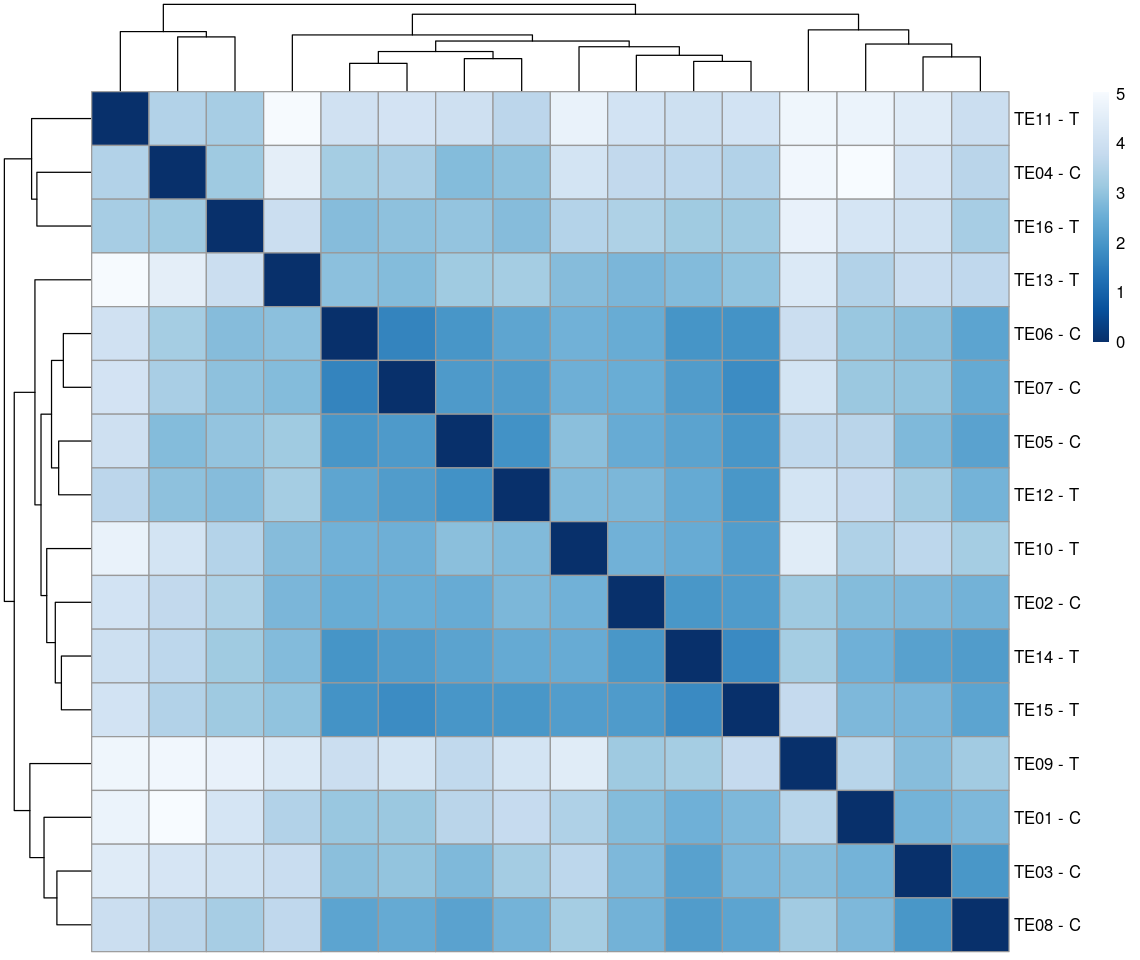

In [169]:
# assess overall similarity between samples
# Heatmap of sample-to-sample distances using the variance stabilizing transformed values
# dendrogram at the side shows the hierarchical clustering of the samples
sampleDists <- dist(t(assay(vsd_te)))
options(repr.plot.width=9.5, repr.plot.height=8)
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(colnames(vsd_te), vsd_te$condition, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette(rev(brewer.pal(9,"Blues")))(255)
pm = pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)
save_pheatmap_png(pm, "DESEQ2_RES/DESEQ2_tecount_heatmap_sample_dist.png")

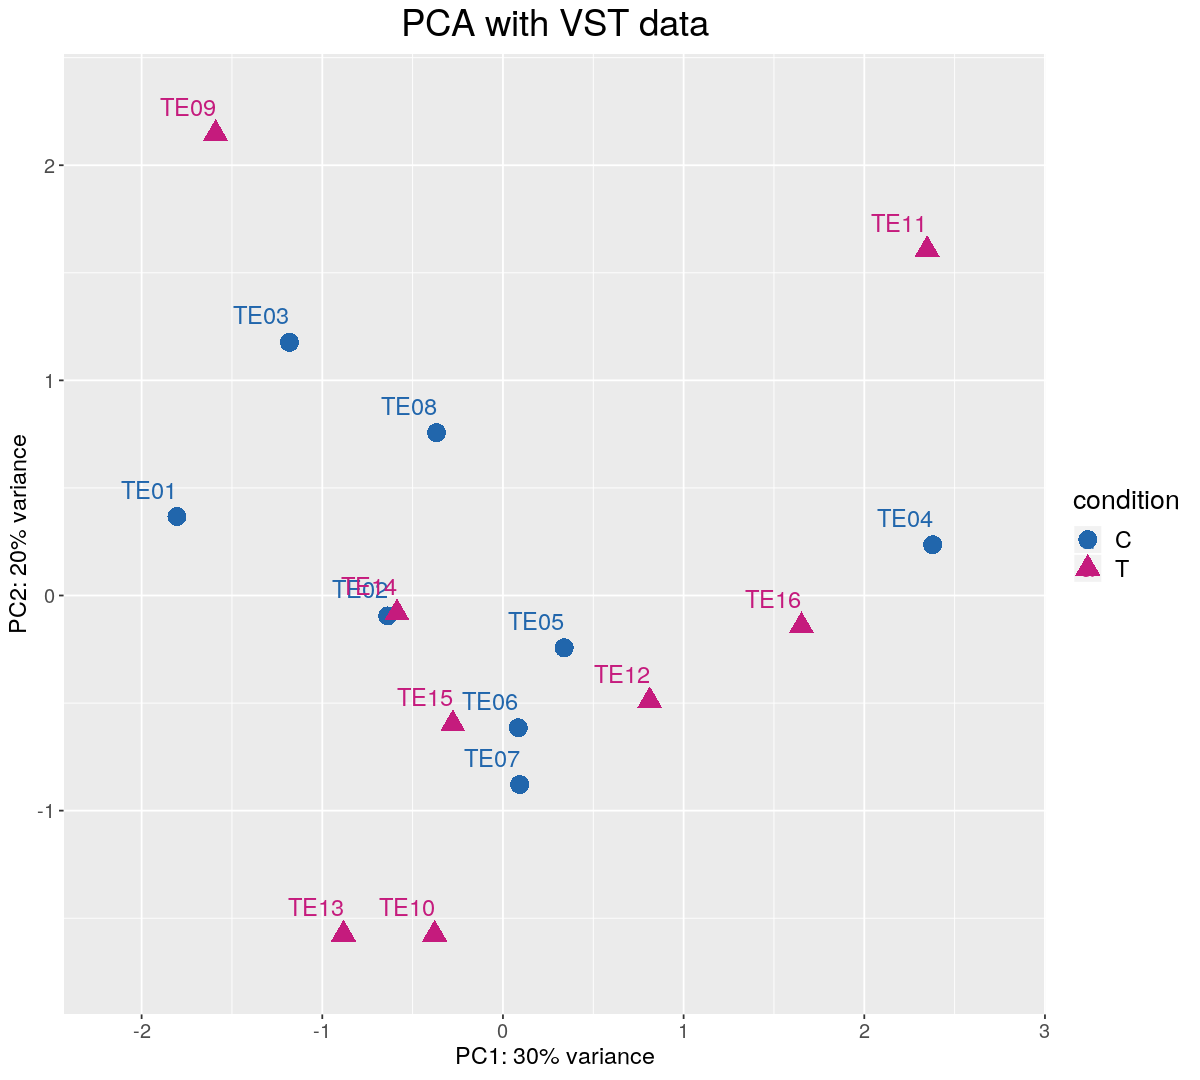

In [170]:
# PCA plot using the VST data
pcaData <- DESeq2::plotPCA(vsd_te, intgroup = colnames(colData(vsd_te)[1]), returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
options(repr.plot.width=10, repr.plot.height=9)
ggplot(pcaData, aes(x = PC1, y = PC2, color=condition, shape=condition)) +
geom_point(size =5) +
geom_text(aes(label=name),hjust=1, vjust=-1, cex=5) +
xlab(paste0("PC1: ", percentVar[1], "% variance")) +
ylab(paste0("PC2: ", percentVar[2], "% variance")) +
scale_x_continuous(expand = c(0.15, 0)) + 
scale_y_continuous(expand = c(0.1, 0)) + 
ggtitle("PCA with VST data") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("DESEQ2_RES/DESEQ2_tecount_PCA_VST_samples.png", width=10, height=9)
invisible(dev.off())

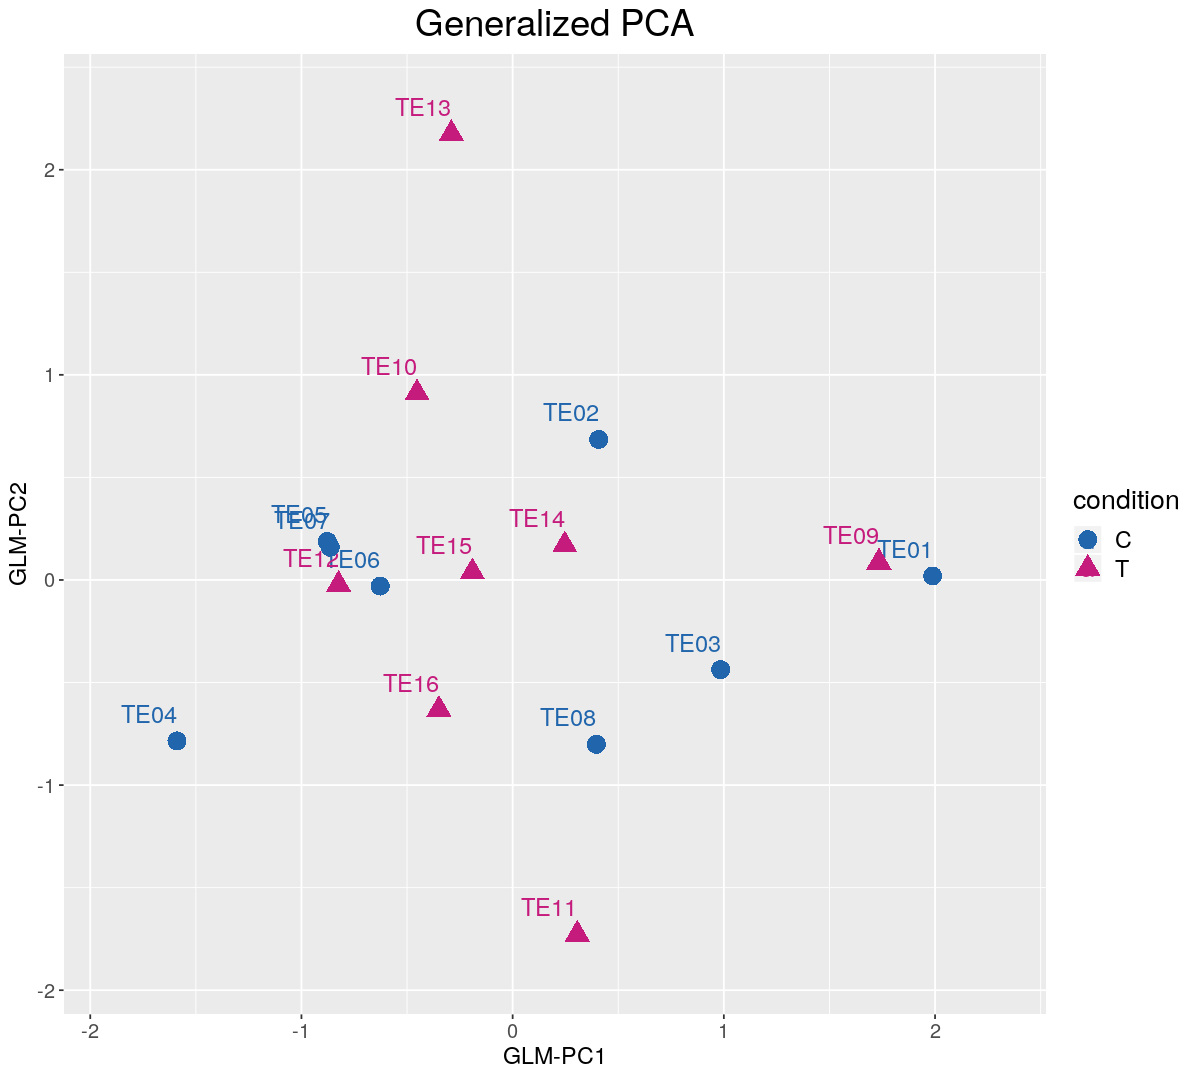

In [221]:
# MUST BE DONE WITH ACCESSION NUMBERS
# generalized principal component analysis (GLM-PCA)
# --> generalization of PCA to exponential family likelihoods
gpca <- glmpca(counts(dds_te), L=2)
gpca.dat <- gpca$factors
gpca.dat$samples <- colnames(dds_te)
gpca.dat$condition <- as.vector(dds_te$condition)
options(repr.plot.width=10, repr.plot.height=9)
ggplot(gpca.dat, aes(x = dim1, y = dim2,  color=condition, shape=condition)) +
geom_text(aes(label=samples),hjust=1, vjust=-1, cex=5, na.rm=TRUE) +
geom_point(size=5, na.rm=TRUE) + 
scale_x_continuous(expand = c(0.15, 0)) + 
scale_y_continuous(expand = c(0.1, 0)) + 
xlab("GLM-PC1") +
ylab("GLM-PC2") +
ggtitle("Generalized PCA") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("DESEQ2_RES/DESEQ2_tecount_GLM-PCA.png", width=10, height=9)
invisible(dev.off())

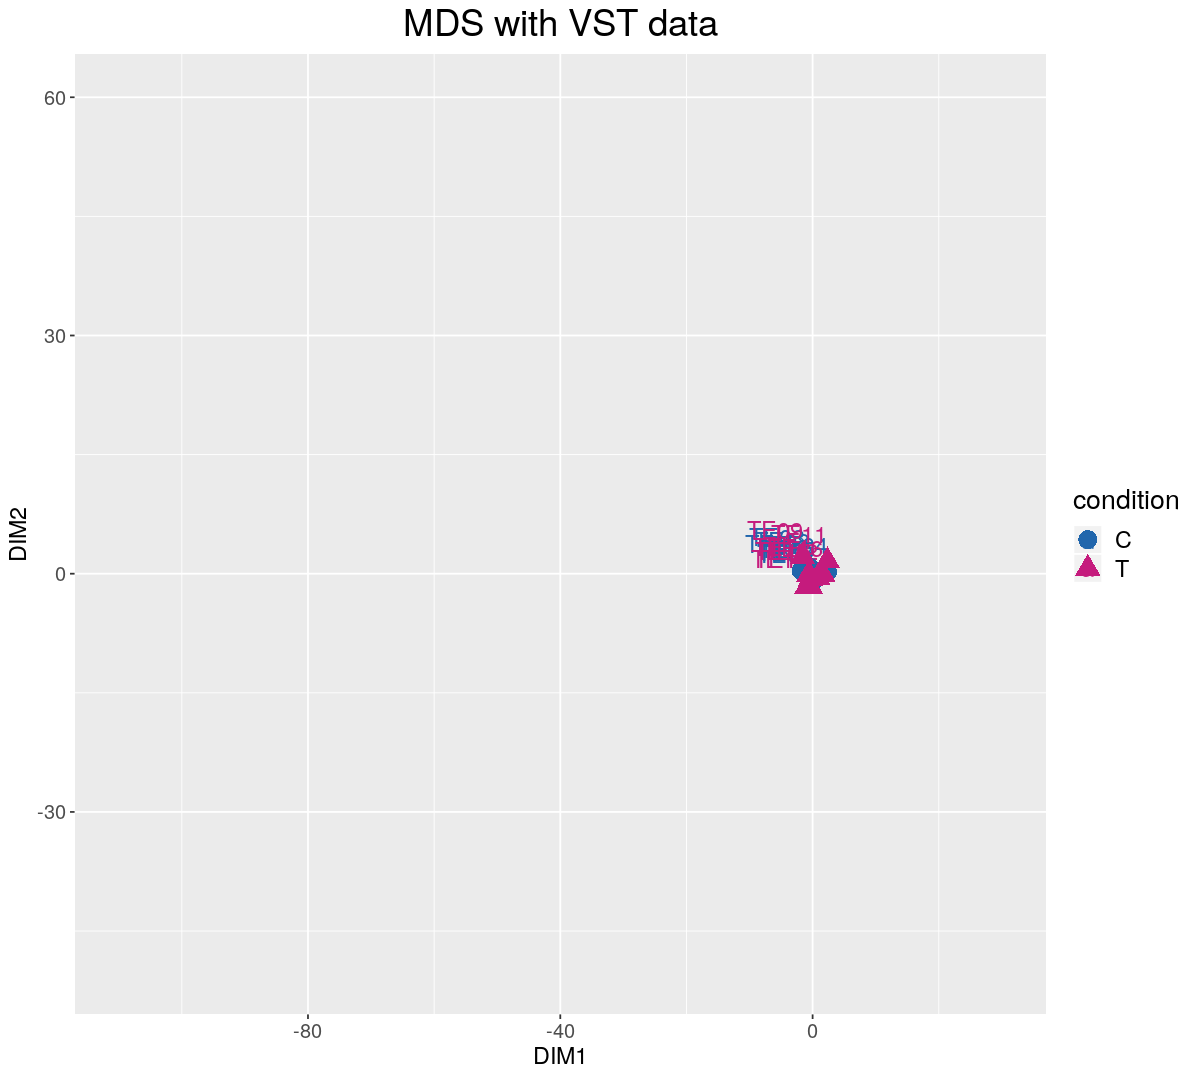

In [171]:
# multidimensional scaling (MDS) plot
options(repr.plot.width=10, repr.plot.height=9)
mds <- as.data.frame(colData(vsd_te)) %>% cbind(cmdscale(sampleDistMatrix))
mds$samples <- colnames(dds_te)
ggplot(mds, aes(x = `1`, y = `2`, color = condition, shape = condition)) +
geom_text(aes(label=samples),hjust=1, vjust=-1, cex=5, na.rm=TRUE) +
geom_point(size=5, na.rm=TRUE) +
xlab("DIM1") +
ylab("DIM2") +
xlim(-110, 30) + 
ylim(-50, 60) + 
ggtitle("MDS with VST data") + 
theme(plot.title = element_text(hjust = 0.5, size=22), 
      axis.text=element_text(size=12),
      axis.title=element_text(size=14), 
      legend.text=element_text(size=14),
      legend.title=element_text(size=16),
      legend.position="right") + 
scale_colour_manual(values = c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]))
ggsave("DESEQ2_RES/DESEQ2_tecount_MDS_VST.png", width=10, height=9)
invisible(dev.off())

In [172]:
# lists the coefficients
resultsNames(dds_te)

[1] "Intercept"        "condition_T_vs_C"

In [173]:
# results with genes symbols
res_te <- DESeq2::results(dds_te, name="condition_T_vs_C")

In [174]:
summary(res_te)
summary <- capture.output(summary(res_te))
fileConn<-file("DESEQ2_RES/DESEQ2_tecount_resultsSummary.txt")
write(summary, fileConn)
close(fileConn)


out of 179 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



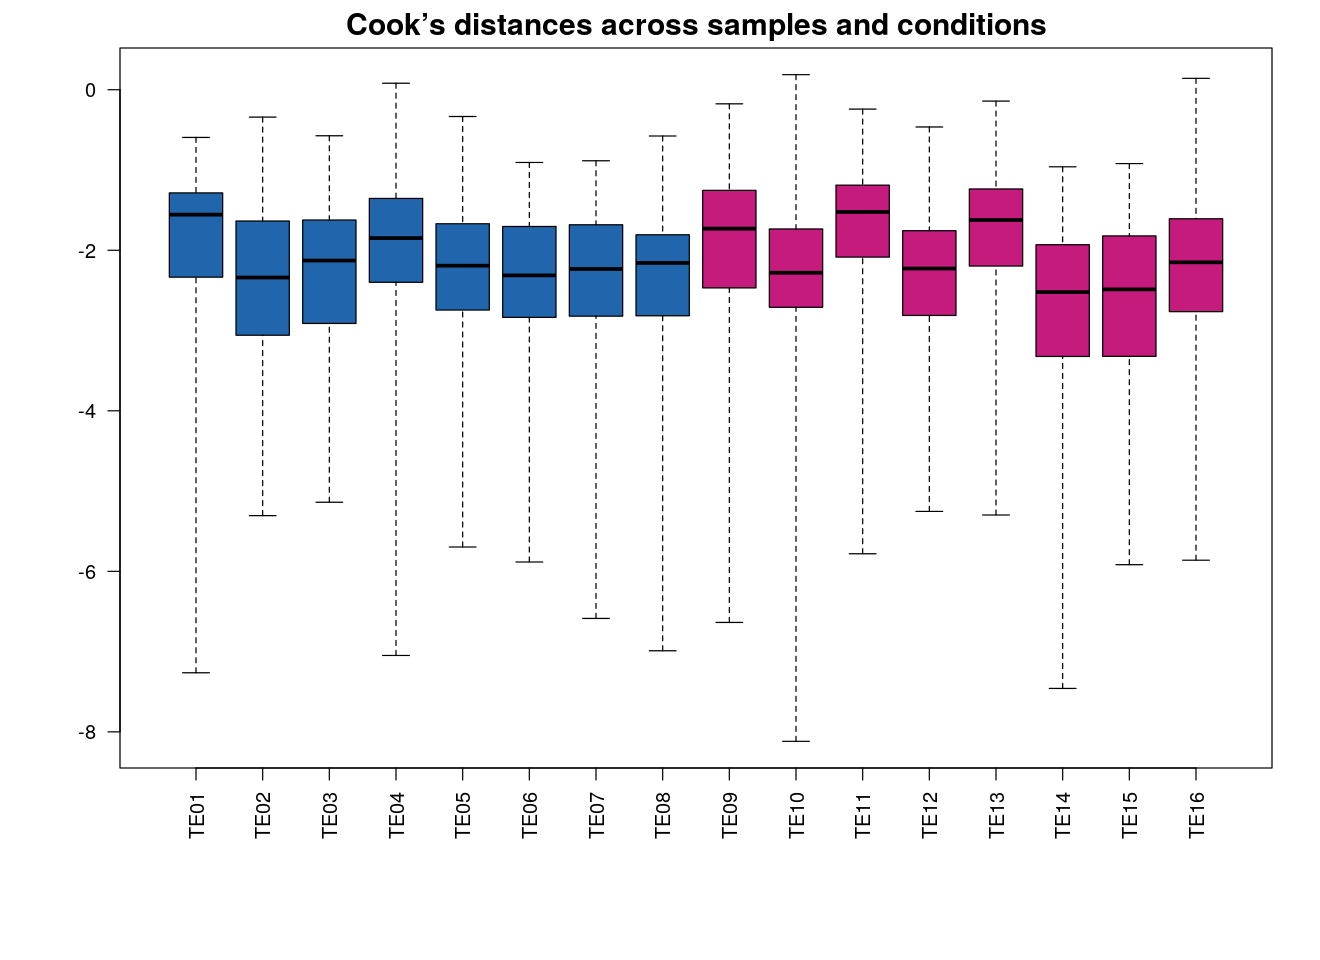

In [175]:
# boxplot of the Cook’s distances to see if one sample is consistently higher than others
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=11, repr.plot.height=8)
par(mar=c(8,5,2,2))
boxplot(log10(assays(dds_te)[["cooks"]]), 
        range=0, 
        las=2, 
        col=col,
        main="Cook’s distances across samples and conditions",
        cex.main=1.5)
invisible(dev.print(png, "DESEQ2_RES/DESEQ2_tecount_cook_boxplot.png", width=640, height=480))

In [176]:
# top DE TE
rownames(head(res_te[ order(res_te$pvalue), decreasing = FALSE]))

[1] "L1M4c"       "L1PB2"       "L1M6B"       "L1MEf"       "L1M3e"      
[6] "HERVL18-int"

In [183]:
# significant TEs up-regulated in C group
rownames(head(res_te[ order(res_te$log2FoldChange), ]))

[1] "L1P4c"       "L1P3b"       "L1P4b"       "HERVL18-int" "AluYh9"     
[6] "L1P"

In [178]:
# significant TEs up-regulated in T group
rownames(head(res_te[ order(res_te$log2FoldChange, decreasing = TRUE), ]))

[1] "L1M3e"  "L1P2"   "L1M2a1" "L1M3b"  "L1M3d"  "L1MEa"

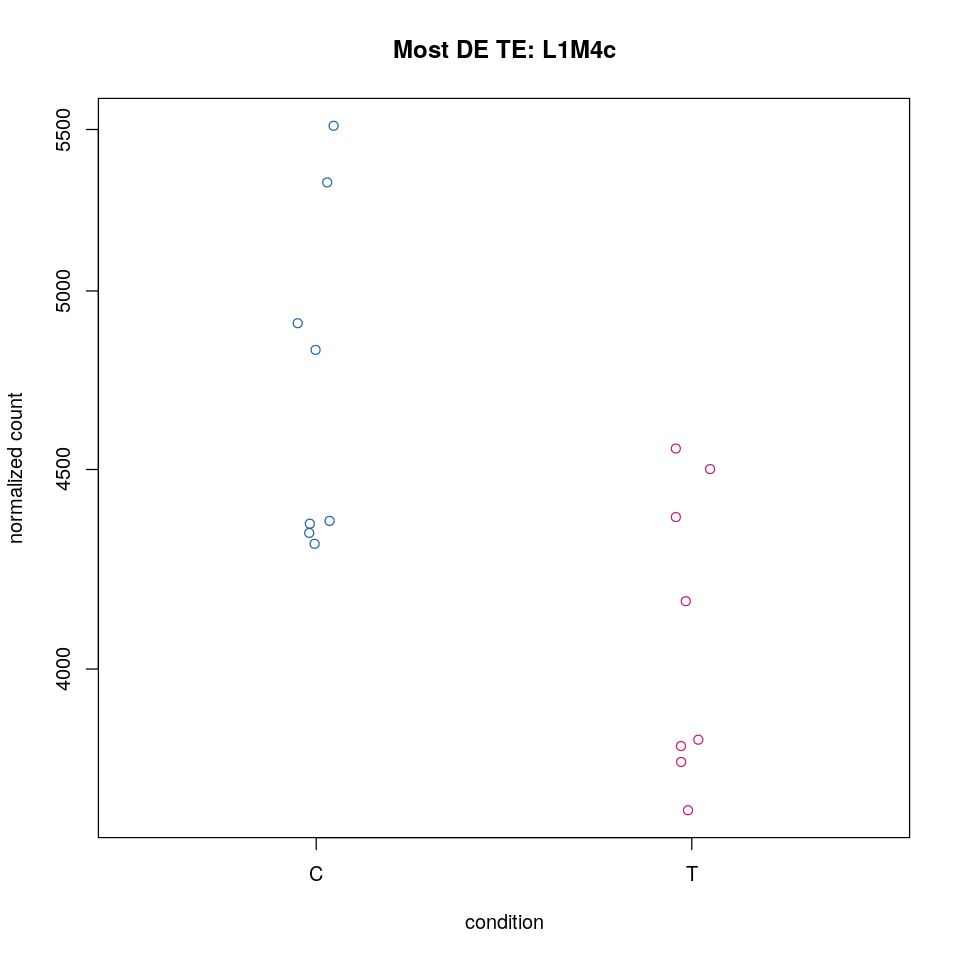

In [179]:
# retrieve the gene that has the lowest adjusted p value (= max differential expression)
# examine the counts of reads for this gene across the groups
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=8, repr.plot.height=8)
topTE <- rownames(dds_te)[which.min(res_te$padj)]
plotCounts(dds_te, 
           gene = topTE, 
           intgroup=c("condition"), 
           col=col,
           main=paste0("Most DE TE: ", topTE),
           xlab="condition")
invisible(dev.print(png, 
                    "DESEQ2_RES/DESEQ2_tecount_topDEte_counts.png", 
                    width=480, 
                    height=480))

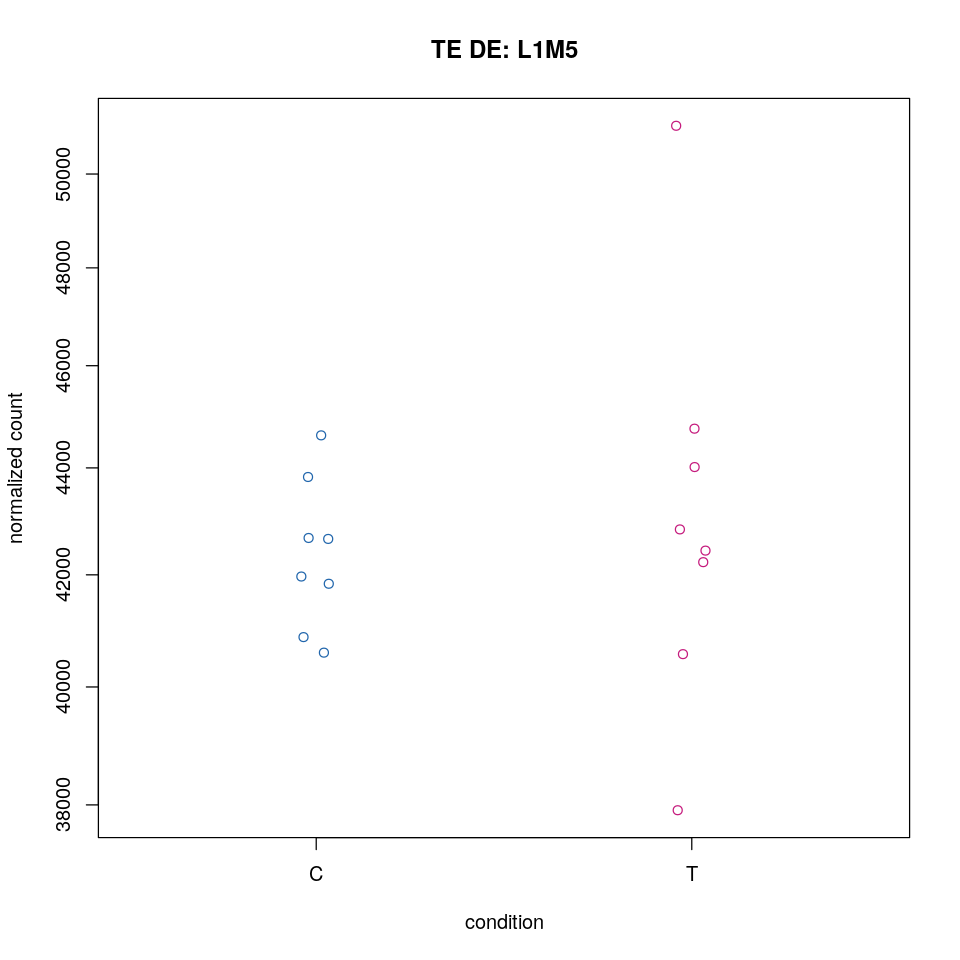

In [218]:
# examine the counts of reads for TP53 across the groups
col <- rep(c(brewer.pal(8, "RdBu")[8], brewer.pal(8, "PiYG")[1]), each = 8)
options(repr.plot.width=8, repr.plot.height=8)
plotCounts(dds_te, 
           gene = "L1M5", 
           intgroup=c("condition"), 
           col=col,
           main=paste0("TE DE: ", "L1M5"),
           xlab="condition")
invisible(dev.print(png, "DESEQ2_RES/DESEQ2_tecount_L1M5_counts.png", width=480, height=480))

In [186]:
# shrink log fold changes association with condition for GENES
# APEGLM = Approximate Posterior Estimation for GLM coefficients
# preserving signal strength while shrinking away noise
resApeglm_te <- lfcShrink(dds_te, coef="condition_T_vs_C", type="apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [187]:
# 'coef=2' --> order rather than name
# NORMAL = original DESeq2 shrinkage estimator
resNorm_te <- lfcShrink(dds_te, coef=2, type="normal")

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [188]:
# ASHR = Adaptive Shrinkage (fitted mixture of normals prior)
resAsh_te <- lfcShrink(dds_te, coef=2, type="ashr")

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



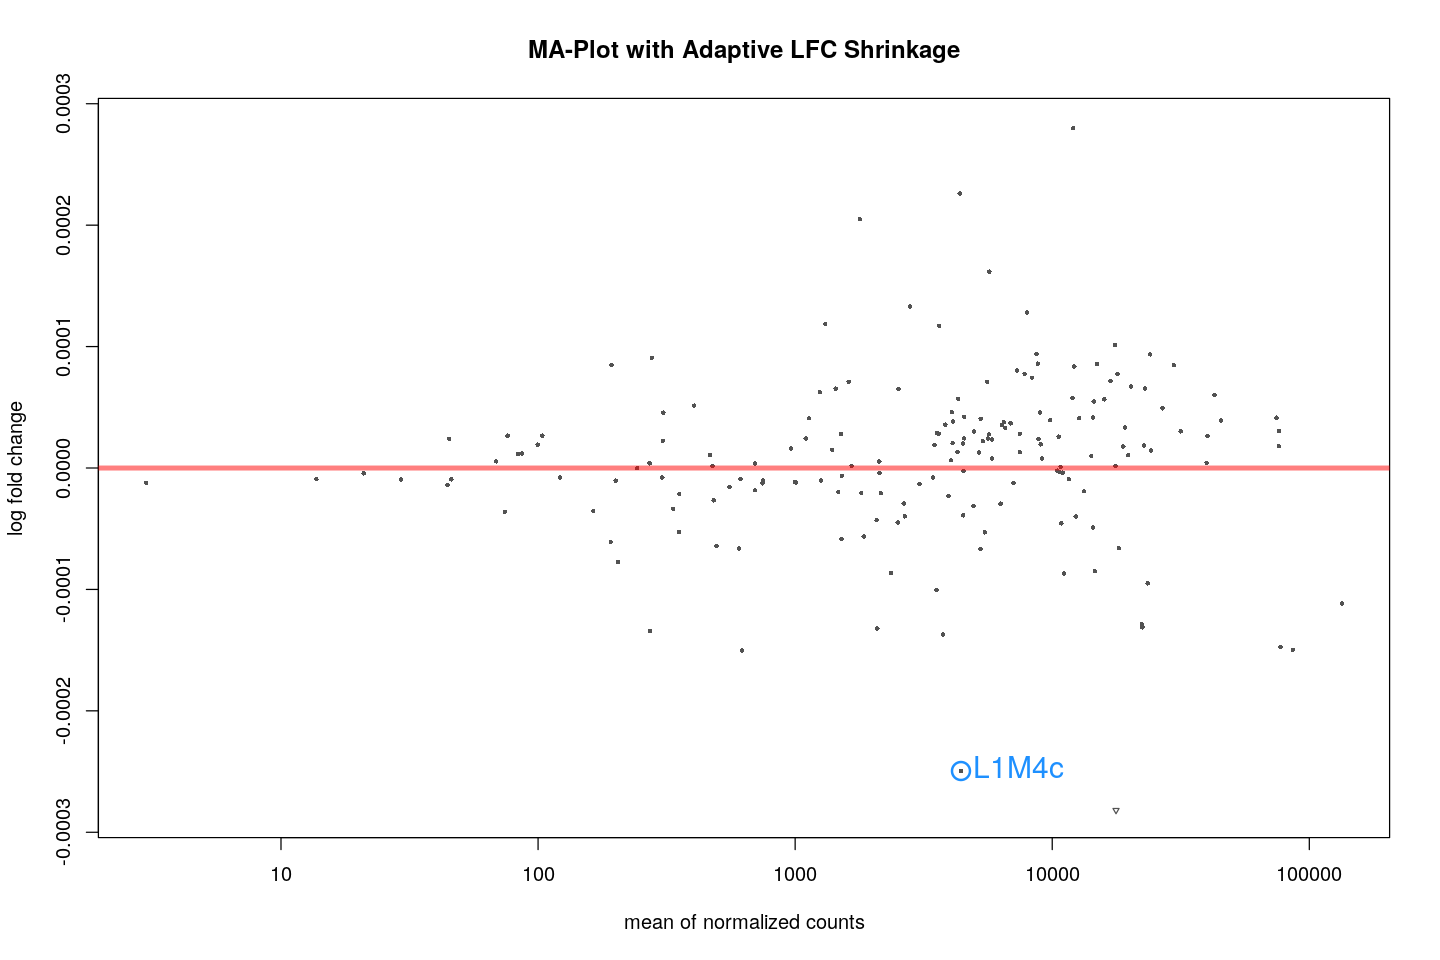

In [190]:
# MA plot
# M (log ratio) and A (mean average)
# scatter plot of log2 fold changes (y-axis) 
# versus the mean of normalized counts (x-axis)
# shows the log2 fold changes attributable to a given variable 
# over the mean of normalized counts for all samples
# --> how different samples are in terms of signal intensities
# + spot the most differentially expressed gene
options(repr.plot.width=12, 
        repr.plot.height=8)
plotMA(resAsh_te, 
       #xlim=xlim, 
       #ylim=c(-3,6), 
       cex=0.5, 
       main="MA-Plot with Adaptive LFC Shrinkage")
with(resAsh_te[topTE, ], {
  points(baseMean, 
         log2FoldChange, 
         col="dodgerblue", 
         cex=2, 
         lwd=2)
  text(baseMean, 
       log2FoldChange, 
       topTE, 
       pos=4, 
       col="dodgerblue", 
       cex=1.5)
})
invisible(dev.print(png, 
                    "DESEQ2_RES/DESEQ2_tecount_MAplot.png", 
                    width=720, 
                    height=480))

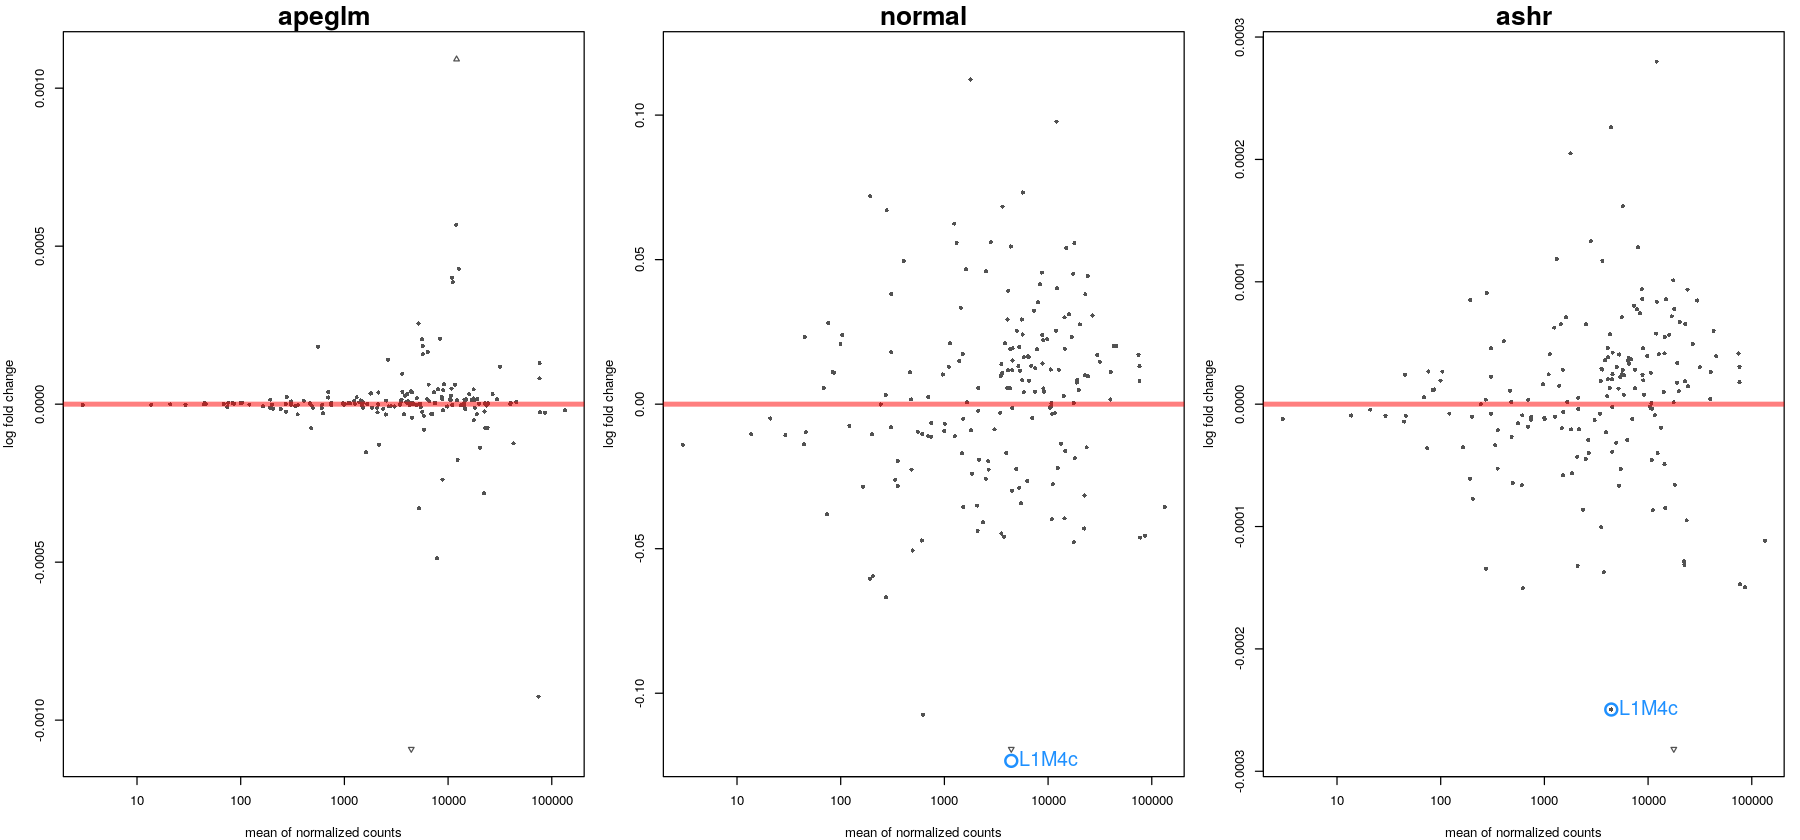

In [192]:
# plot comparison of shrinkage algorithms
options(repr.plot.width=15, repr.plot.height=7)
par(mfrow=c(1,3), mar=c(4,4,2,1))
plotMA(resApeglm_te, main="apeglm", cex=0.7, cex.main=2)
with(resApeglm_te[topTE, ], {
  points(baseMean, 
         log2FoldChange, 
         col="dodgerblue", 
         cex=2, 
         lwd=2)
  text(baseMean, 
       log2FoldChange, 
       topTE, 
       pos=4, 
       col="dodgerblue", 
       cex=1.5)
})
plotMA(resNorm_te, main="normal", cex=0.7, cex.main=2)
with(resNorm_te[topTE, ], {
  points(baseMean, 
         log2FoldChange, 
         col="dodgerblue", 
         cex=2, 
         lwd=2)
  text(baseMean, 
       log2FoldChange, 
       topTE, 
       pos=4, 
       col="dodgerblue", 
       cex=1.5)
})
plotMA(resAsh_te, main="ashr", cex=0.7, cex.main=2)
with(resAsh_te[topTE, ], {
  points(baseMean, 
         log2FoldChange, 
         col="dodgerblue", 
         cex=2, 
         lwd=2)
  text(baseMean, 
       log2FoldChange, 
       topTE, 
       pos=4, 
       col="dodgerblue", 
       cex=1.5)
})
invisible(dev.print(png, "DESEQ2_RES/DESEQ2_tecount_shrinkage_algorithms.png", width=920, height=480))

In [197]:
topVarTEs

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

In [198]:
# subset of the 20 most highly variable genes from VST data
#topVarTEs <- head(which(res_te$padj < 1),decreasing = FALSE, 20)
topVarTEs <- head(order(rowVars(assay(vsd_te)), decreasing = FALSE), 20)
mat  <- assay(vsd_te)[topVarTEs,]
mat  <- mat - rowMeans(mat)
mat

,TE01,TE02,TE03,TE04,TE05,TE06,TE07,TE08,TE09,TE10,TE11,TE12,TE13,TE14,TE15,TE16
L1MB7,-0.072957866,0.006853076,0.0007503721,0.048933063,0.0218317470,0.024632666,0.031931685,0.0075434808,-0.0401176530,-0.001312991,0.053735243,0.084074784,-0.09618177,-0.052832226,-0.023720600,0.0068369922
L1M,0.003488600,-0.024037816,0.0408333764,0.044264828,-0.0003966889,0.055944893,0.051284905,0.0791983189,-0.0008859407,-0.010677519,-0.098880220,0.012747578,-0.08093478,-0.060657269,0.012249205,-0.0235414658
L1MB3,-0.058395913,-0.025058066,0.0851080869,0.088928148,0.0653010182,-0.037141026,-0.061008844,0.0144606734,-0.0173742801,-0.096217895,0.068424461,0.006350235,-0.03560021,0.013843045,-0.020139617,0.0085201838
AluYk12,-0.118489709,-0.050073924,0.0227972229,-0.004084012,0.0212585948,0.017436163,-0.022998331,0.0178294267,0.0179097489,0.059419344,-0.005897573,-0.049344385,-0.06512226,0.096288271,0.089362822,-0.0262914026
L1MB8,0.034503364,-0.046400933,0.0585732782,0.063780947,0.0623485302,-0.020110118,-0.015468461,0.0804435773,0.0236603569,-0.084963374,0.030805761,-0.050594083,-0.10686870,-0.049855948,0.019816166,0.0003296398
L1ME1,0.027216128,-0.067361510,-0.0241200457,-0.001442493,-0.0637297380,-0.024940233,0.071368587,0.0034809315,0.0010892485,-0.043149962,0.155302557,0.004332544,-0.08271399,-0.024178890,0.039026234,0.0298206360
AluYi6_4d,0.048075654,-0.005212120,-0.0127180106,0.069060508,-0.0491091639,-0.088536382,0.047913759,0.0572991535,-0.0036214234,-0.073495494,0.077182354,0.049313844,0.04230355,-0.040107300,0.012587053,-0.1309359802
L1ME3,-0.101190619,0.077861565,0.0021641345,0.006070402,0.0675560715,0.009649093,-0.095804483,-0.0078221525,-0.0254238087,-0.024898583,0.118948568,-0.012667461,-0.03623617,-0.044328779,-0.036837724,0.1029599472
AluYk11,-0.122354774,0.044354165,0.0788163109,0.061452536,0.0220863432,-0.021660316,-0.001144965,0.0756958316,-0.0583359333,0.006801331,-0.133578163,-0.016890456,0.03860103,0.006600157,-0.045439211,0.0649961192
L1MB4,-0.053491002,-0.018340575,0.0422258750,0.074308390,-0.0635982272,0.028062294,-0.007070925,-0.0947298683,0.0107685227,-0.056870222,0.150895005,0.038504196,-0.04368153,0.066654471,0.009549758,-0.0831861653


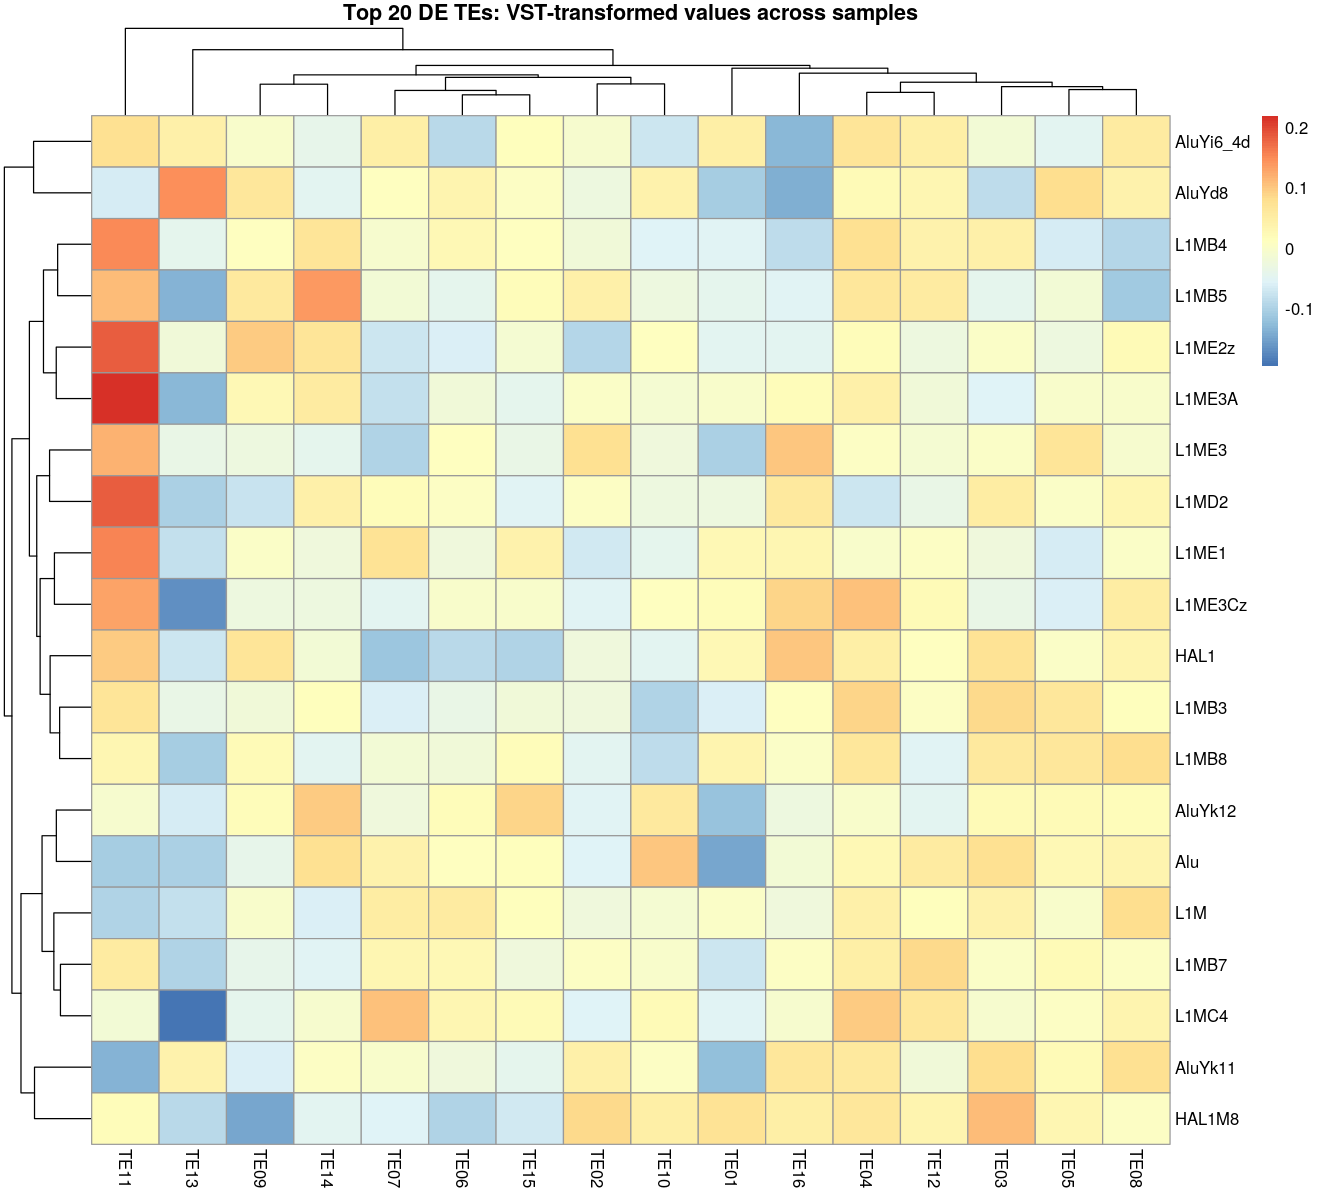

In [199]:
# Heatmap of relative VST-transformed values across samples
# Blocks of genes that covary across patients
# intensity = higher gene expression
options(repr.plot.width=11, repr.plot.height=10)
pm = pheatmap(mat, main="Top 20 DE TEs: VST-transformed values across samples")
save_pheatmap_png(pm, "DESEQ2_RES/DESEQ2_tecount_heatmap_topDEte_VST.png")

In [201]:
# add add rep_name column to results dataframe
res_te$rep_name <- rownames(res_te)
col_order <- c('rep_name','baseMean','log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj')
invisible(res_te <- res_te[, col_order])
# reorder by increasing padj
res_te_ord <- res_te[ order(res_te$padj, decreasing = FALSE), ]
# export DESeq2 processed results sorted by p-values
write.table(res_te_ord, 
            file = "DESEQ2_RES/DESEQ2_tecount_results.txt", 
            row.names = F, 
            sep = "\t", 
            quote = F)